Homework 3 (due 07/16/2024) \\
Author: Warren Shepard \\
Collaboration: Sri Korandla, Tushar Agarwal \\
Date: 13 July 2024

# Eigenbears

## Instructions

#### Part 1: Data preparation (ALREADY COMPLETED)
The folder that contains this notebook also contains a data set of pictures of pandas and brown bears.
1. Load the images for train and test.
2. Reduce their size/resolution by 50%.
3. Convert the colors to grey scale.
4. Display a few of the images.

#### Part 2: Singular value decomposition (FOR YOU TO COMPLETE)
1. Follow the steps in the eigenfaces tutorial from the UW databook [[link]](https://github.com/dynamicslab/databook_python/blob/master/CH01/CH01_SEC06_2_3_4.ipynb) to perform an SVD on the images.
2. Note that you will need to "center the data" before doing the SVD. Data centering means replacing each variable $X_i$ with a new variable $X_i'$ that is equal to $X_i$ minus $X_i$'s mean value. (Think carefully about whether you want to use the mean of train set, test set, or the full data set for this.)
3. Display the first four "eigenbears" (i.e., the images associated with the first four eigenvectors). Explain what you see.
4. The singular vectors are sometimes called "principal components". Principal component analysis (PCA) is a data analysis method for which one projects high-dimensional data into the subspace of the first two singular vectors. Use the code scaffold provided below do perform PCA for the bears data. What do you notice?

#### Part 3: Non-parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Build a $k$-nearest-neighbors model with the train set, and test its accuracy on the test set. (ALREADY COMPLETE)
2. Try different values of $k$ between 1 and 15. For what value do you get the best test accuracy? (FOR YOU TO COMPLETE)
3. Which bears seem to be hard to classify? Display them.
4. What might make them hard to classify?

#### Part 4: Parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Try using logistic regression and LDA to classify the bears.
2. What method gives you the best test accuracy?
3. How does the result compare to the non-parametric classification?
4. One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.

#### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

--------------------------------

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os, time

In [ ]:
# IMPORTANT: may need to change this to fit wherever you have the files saved in order to run
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/24X/M76

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/24X/M76


## Part 1: Data preparation

In [ ]:
# toggle settings
add_noise = False

# Initiliaze lists for image collection
train_images = []
test_images = []

for i, images in enumerate([train_images, test_images]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = 'PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = 'PandasBears/{}/Bears/'.format(datasetname)


    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')

        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):

            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1

                # Construct full file path
                file_path = os.path.join(folder_path, filename)

                # import image
                image = plt.imread(file_path, format='jpeg')

                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)

                # add the new image to collection
                images.append(image)

        print('has {} images'.format(file_count))

PandasBears/Train/Pandas/ has 250 images
PandasBears/Train/Bears/ has 250 images
PandasBears/Test/Pandas/ has 50 images
PandasBears/Test/Bears/ has 50 images


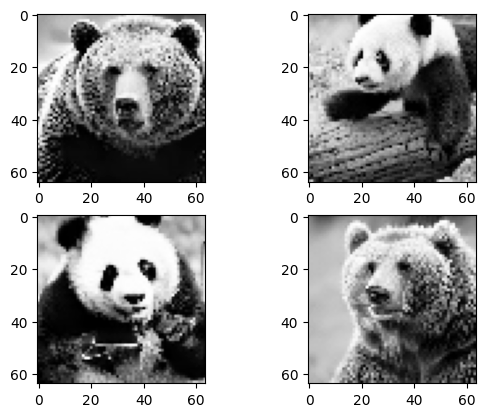

In [ ]:
# look at 4 random bears
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

# Part 2: Singular value decomposition

In [ ]:
# Construct data matrix of centered data

# use training data only?

# first convert to an np array
np_train_images = np.array(train_images).reshape(500,128*128).T

print(np_train_images.shape)

# compute average
ave_bear = np.mean(np_train_images, axis=0)

# compute the mean-subtraced training data
X = np_train_images - ave_bear

print(X.shape)

# Perform SVD
U, S, Vh = np.linalg.svd(X, full_matrices=False) # replace A with your centered data matrix

(16384, 500)
(16384, 500)


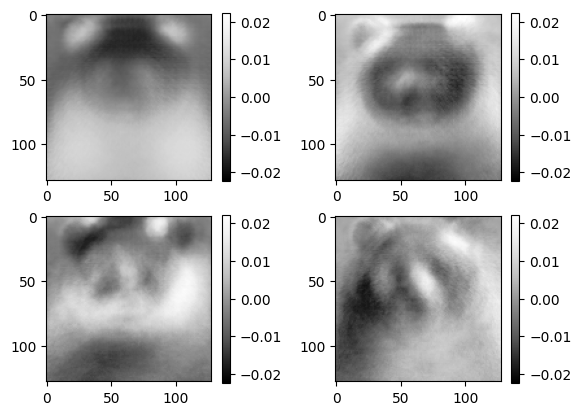

In [ ]:
# show the first four eigenbears
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow((U[:,i]).reshape((128,128)), cmap='Greys_r',
        # force colormap to be the same for all four
        vmin=-np.max(np.abs(U[:,:4])),
        vmax=np.max(np.abs(U[:,:4])))
    plt.colorbar()
plt.subplots_adjust(wspace=0.4)

Above, we see the first eigenbears, which are essentially the "eigenfaces" but for the bear images. This is the result of singular value decomposition, where we can see statistically importnat features.

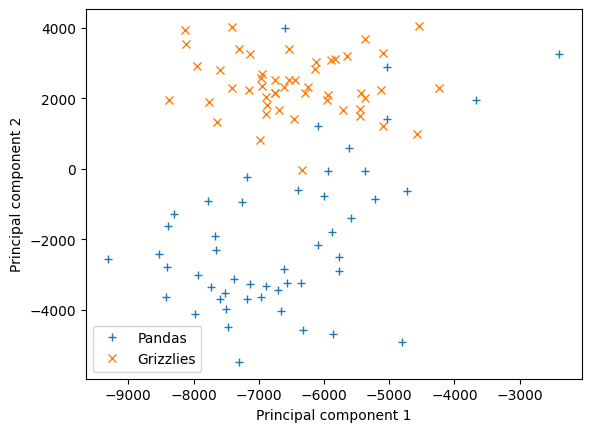

In [ ]:
# Clustering of panda bears and brown bears along the first and second principal component
# indices of pandas in the test set
indices_pandas = range(50)
# indices of brown bears in the test set
indices_brownbears = range(50,100)

for i, indices in enumerate([indices_pandas, indices_brownbears]):
    # get projections of data onto principal component 1
    p1 = [np.dot(U[:,0],np.ravel(test_images[x])) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:,1],np.ravel(test_images[x])) for x in indices]
    plt.plot(p1, p2, marker='+x'[i], lw=0, label=['Pandas', 'Grizzlies'][i])

# annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# add legend
plt.legend()

PCA has been performed above, and we can see Principle component 1 and principle component 2 graphed out. There is a clear separation between the two classes of bears (Pandas and Grizzlies). This indicates that just the first two principal components are effective at capturing the variance in the dataset that distinguishes between these two types of bears. In the x axis, representing component 1, there is not much difference between the pandas and grizzlies. However, in the second principle component, represented on the y-axis, we can see that there is a larger separation there, idnicating that the second principle component caputres more variation between the bears.

# Part 3: Nonparametric classification
1. Build a $k$-nearest-neighbors model with the train set, and test its accuracy on the test set. (ALREADY COMPLETE)
2. Try different values of $k$ between 1 and 15. For what value do you get the best test accuracy? (FOR YOU TO COMPLETE)
3. Which bears seem to be hard to classify? Display them.
4. What might make them hard to classify?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.
y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the
# list of test images. We code pandas as '0' and brown bears as '1'.
y_test = np.concatenate([np.zeros(50), np.ones(50)])

Note: I added some code below to maintain a **dictionary** with keys as misclassified bears and values as which value of k they are misclassified for.

In [ ]:
print('   k\t|  # errors\t| misclassified bears')
print('--------------------------------------------')

# dictionary for keeping track of misclassified bears
misclassified_bears = {}

for k in range(1,16):

    # fit KNN model
    # replaced A with X
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(X.T, y_train)

    # use model to make predictions on the test set
    # IMPORTANT: changed this line becuase of critical error (you cannot iterate over an integer, you have to use the `range` keyword)
    # predictions = [mrodelKN.predict([np.ravel(test_images[i])]) for i in len(y_test)]
    predictions = [modelKN.predict([np.ravel(test_images[i])]) for i in range(len(y_test))]

    # detect misclassifications
    errors = np.abs((np.array(predictions).T)[0]-y_test)

    # print results to table
    print('    {}\t|      {} \t| {}'.format(k, int(np.sum(errors)), (np.argwhere(errors).T)[0]))

    for fake_bear in np.argwhere(errors).T[0]:
      if fake_bear not in misclassified_bears:
        misclassified_bears[fake_bear] = [k]
      else:
        misclassified_bears[fake_bear].append(k)

   k	|  # errors	| misclassified bears
--------------------------------------------
    1	|      2 	| [ 7 22]
    2	|      0 	| []
    3	|      5 	| [ 0  7 22 27 29]
    4	|      2 	| [22 29]
    5	|      3 	| [ 7 22 29]
    6	|      3 	| [ 7 22 29]
    7	|      5 	| [ 0  7 12 22 29]
    8	|      4 	| [ 0  7 22 29]
    9	|      6 	| [ 0  7 22 27 29 31]
    10	|      6 	| [ 0  7 22 27 29 31]
    11	|      6 	| [ 0  7 22 27 29 31]
    12	|      6 	| [ 0  7 22 27 29 31]
    13	|      6 	| [ 0  7 22 27 29 31]
    14	|      5 	| [ 7 22 27 29 31]
    15	|      6 	| [ 7 22 27 29 31 45]


Clearly, $k=2$ works the best since NO bears are misclassified.

7 [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


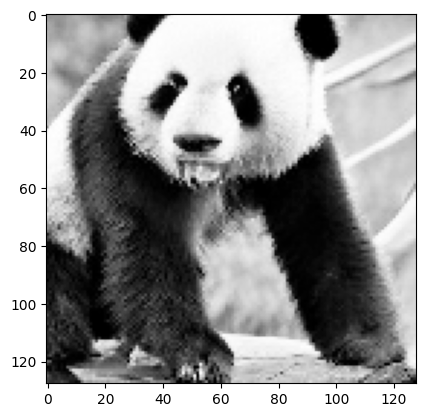

22 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


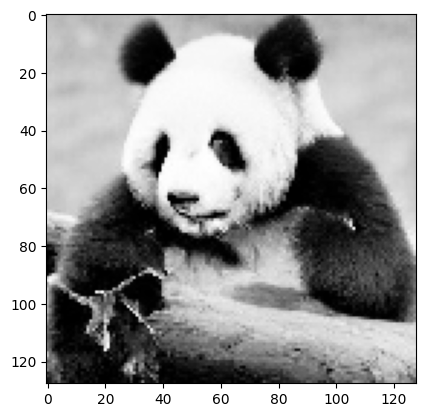

0 [3, 7, 8, 9, 10, 11, 12, 13]


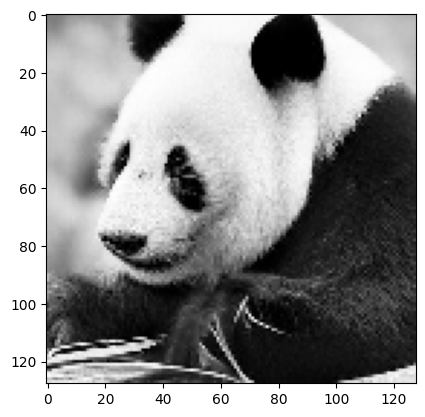

27 [3, 9, 10, 11, 12, 13, 14, 15]


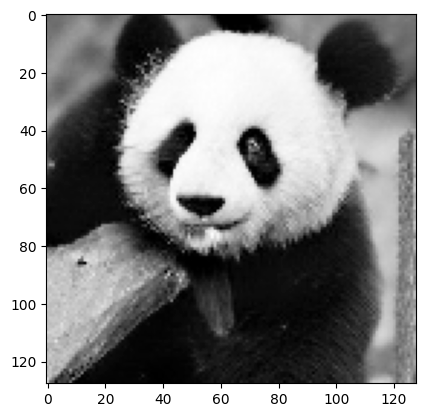

29 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


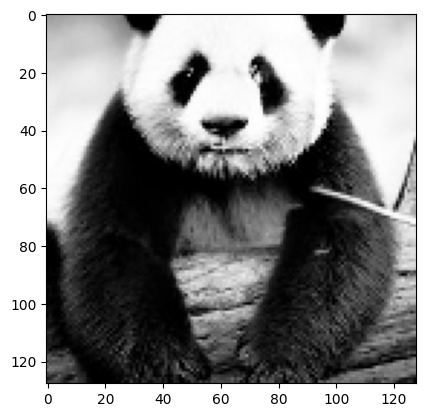

12 [7]


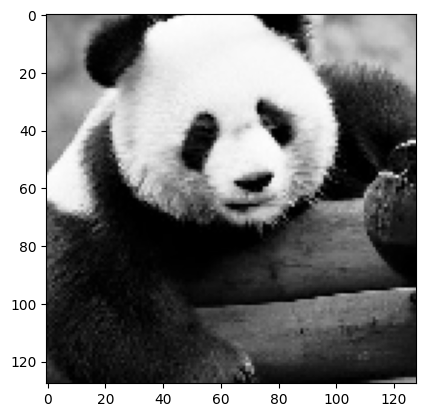

31 [9, 10, 11, 12, 13, 14, 15]


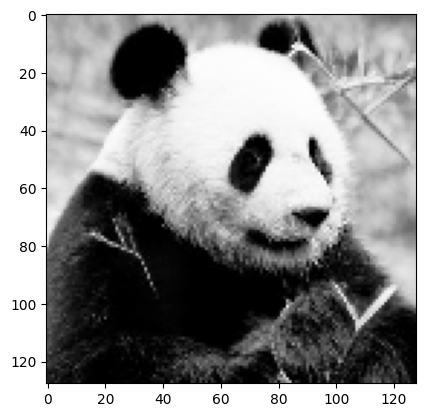

45 [15]


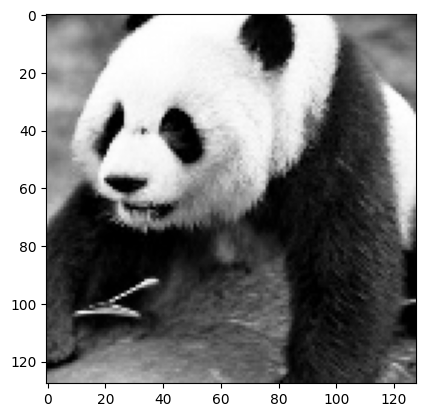

In [ ]:
# Show hard-to-classify bears
for k in misclassified_bears:
    print(k, misclassified_bears[k])
    plt.imshow(test_images[k], cmap='Greys_r')
    plt.show()

Clearly we always have pandas being misclassified as brown bears. This makes sense given that in the plot above, some pandas have negative Principle Component 2 values, whereas no brown bears have positive values.

# Part 4: Parametric classification
1. Try using logistic regression and LDA to classify the bears.
2. What method gives you the best test accuracy?
3. How does the result compare to the non-parametric classification?
4. One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
# Recall that we already have the following code somewhere above:

# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.

y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the
# list of test images. We code pandas as '0' and brown bears as '1'.
y_test = np.concatenate([np.zeros(50), np.ones(50)])

In [ ]:
# LOGISTIC REGRESSION

# flatten training and testing arrays
X_train = np.array(train_images).reshape(500,128*128)
X_test = np.array(test_images).reshape(100,128*128)

# create model
model_log_reg = LogisticRegression()

# train model
model_log_reg.fit(X_train, y_train)

# test the model--make predictions
y_pred = model_log_reg.predict(X_test)

# compute accuracy
accuracy = np.mean(y_pred == y_test)
print("LOGISTIC REGRESSION ACCURACY: ", accuracy)


LOGISTIC REGRESSION ACCURACY:  1.0


In [ ]:
# LINEAR DISCRIMINANT ANALYSIS

# can use the same trining and testing data as previous block

# create model
model_lda = LinearDiscriminantAnalysis()

# train model
model_lda.fit(X_train, y_train)

# test the model--make predictions
y_pred = model_lda.predict(X_test)

# compute accuracy
accuracy = np.mean(y_pred == y_test)
print("LDA ACCURACY: ", accuracy)


LDA ACCURACY:  0.99


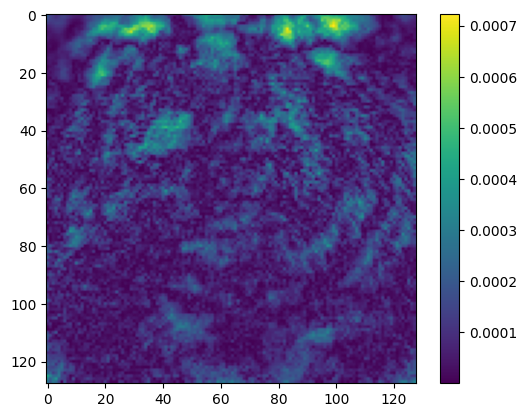

In [ ]:
# Construct the bear mask:
# Show absolute value of logistic-regression coefficients for each pixel
plt.imshow(np.abs((model_log_reg.coef_).reshape((128,128))))
plt.colorbar()

Logistic regression gave us the best accuracy, with an accuracy of 100% compared to 99%. Compared to non-parametric classificaiton, parametric performed better. The bear mask displayed in the image represents the absolute values of the logistic regression coefficients for each pixel in the bear images. This visualization is a way to interpret the model and understand which pixels/regions of the image have the most influence on the classification decision. The brighter / yellower regions have a higher coefficient value, meaning they were more important for classification decision making.

#### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

In [ ]:
# toggle settings
add_noise = True # NOISE ENABLED FOR PART 5

# Initiliaze lists for image collection
train_images_noisy = []
test_images_noisy = []

for i, images_noisy in enumerate([train_images_noisy, test_images_noisy]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = 'PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = 'PandasBears/{}/Bears/'.format(datasetname)


    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')

        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):

            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1

                # Construct full file path
                file_path = os.path.join(folder_path, filename)

                # import image
                image = plt.imread(file_path, format='jpeg')

                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)

                # add the new image to collection
                images_noisy.append(image)

        print('has {} images'.format(file_count))

PandasBears/Train/Pandas/ has 250 images
PandasBears/Train/Bears/ has 250 images
PandasBears/Test/Pandas/ has 50 images
PandasBears/Test/Bears/ has 50 images


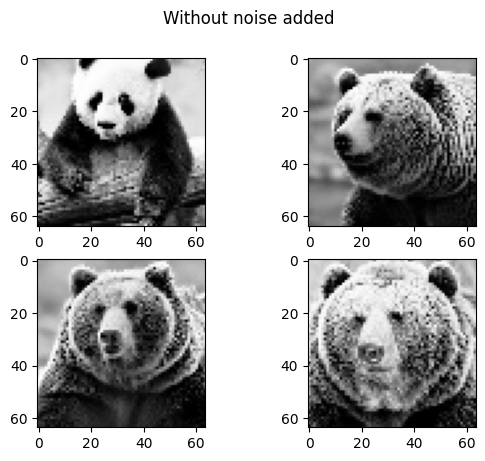

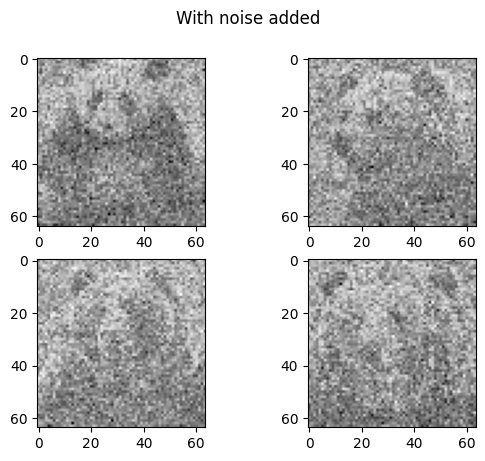

In [ ]:
# display 4 random bears from non-noisy and noisy datasets
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.figure(1)
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

    plt.suptitle("Without noise added")

    plt.figure(2)
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images_noisy[i][::2,::2],cmap='Greys_r')

    plt.suptitle("With noise added")

Text(0.5, 0.98, 'With noise added')

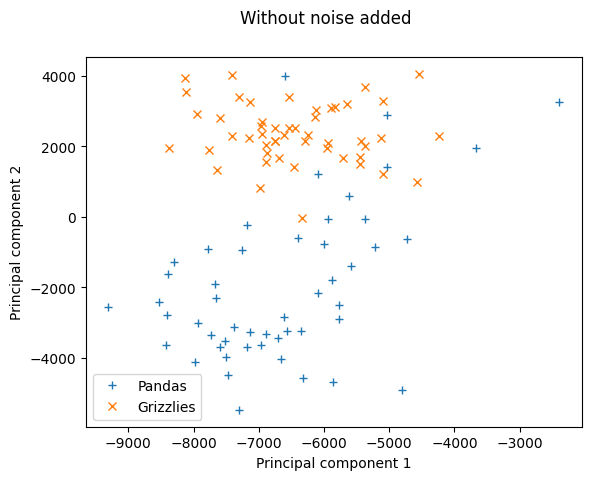

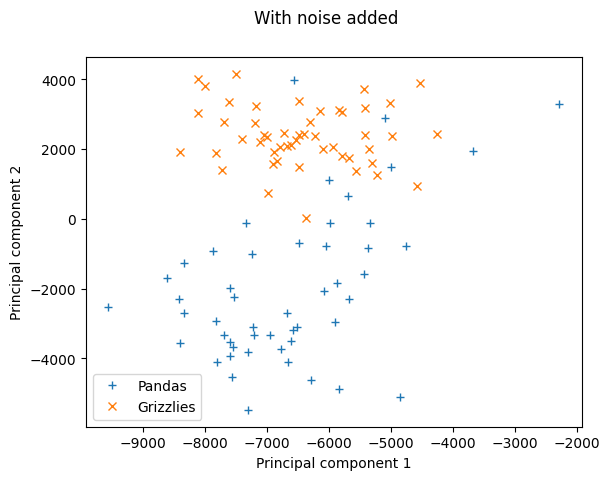

In [ ]:
# Clustering of panda bears and brown bears along the first and second principal component
# indices of pandas in the test set
indices_pandas = range(50)
# indices of brown bears in the test set
indices_brownbears = range(50,100)

for i, indices in enumerate([indices_pandas, indices_brownbears]):
    plt.figure(1)
    # get projections of data onto principal component 1
    p1 = [np.dot(U[:,0],np.ravel(test_images[x])) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:,1],np.ravel(test_images[x])) for x in indices]
    plt.plot(p1, p2, marker='+x'[i], lw=0, label=['Pandas', 'Grizzlies'][i])

    plt.figure(2)
    # get projections of data onto principal component 1
    p1 = [np.dot(U[:,0],np.ravel(test_images_noisy[x])) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:,1],np.ravel(test_images_noisy[x])) for x in indices]
    plt.plot(p1, p2, marker='+x'[i], lw=0, label=['Pandas', 'Grizzlies'][i])

plt.figure(1)
# annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# add legend
plt.legend()
# add title
plt.suptitle("Without noise added")

plt.figure(2)
# annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# add legend
plt.legend()
# add title
plt.suptitle("With noise added")

In [ ]:
# print('   k\t|  # errors w/out noise\t| # errors w/ noise\t|  misclassified bears (w/out noise)\t|  misclassified bears (w/ noise)')
# print('-----------------------------------------------------------------------------------------------------------------------------------')

# dictionary for keeping track of misclassified bears
misclassified_bears = {}
misclassified_bears_noisy = {}

# table for dataframe
table_entries = []

for k in range(1,16):

    # fit KNN model
    # replaced A with X
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(X.T, y_train)

    # use model to make predictions on the test set
    # IMPORTANT: changed this line becuase of critical error (you cannot iterate over an integer, you have to use the `range` keyword)
    # predictions = [mrodelKN.predict([np.ravel(test_images[i])]) for i in len(y_test)]
    predictions = [modelKN.predict([np.ravel(test_images[i])]) for i in range(len(y_test))]
    # predictions for noisy data
    predictions_noisy = [modelKN.predict([np.ravel(test_images_noisy[i])]) for i in range(len(y_test))]


    # detect misclassifications
    errors = np.abs((np.array(predictions).T)[0]-y_test)

    # misclassifications for noisy data
    errors_noisy = np.abs((np.array(predictions_noisy).T)[0]-y_test)

    table_entries.append(
        {
            'K': k,
            '# Errors w/out noise': int(np.sum(errors)),
            '# Errors w/ noise': int(np.sum(errors_noisy)),
            'Misclassified bears w/out noise': (np.argwhere(errors).T)[0],
            'Missclassified bears w/ noise': (np.argwhere(errors_noisy).T)[0]

        }
    )

    # print results to table
    # print('    {}\t|          {} \t\t|          {} \t\t| {}\t| {}\t'.format(k, int(np.sum(errors)), int(np.sum(errors_noisy)), (np.argwhere(errors).T)[0], (np.argwhere(errors_noisy).T)[0]))

    for fake_bear in np.argwhere(errors).T[0]:
      if fake_bear not in misclassified_bears:
        misclassified_bears[fake_bear] = [k]
      else:
        misclassified_bears[fake_bear].append(k)

    for fake_bear in np.argwhere(errors_noisy).T[0]:
      if fake_bear not in misclassified_bears_noisy:
        misclassified_bears_noisy[fake_bear] = [k]
      else:
        misclassified_bears_noisy[fake_bear].append(k)



pd.DataFrame(table_entries)

K  # Errors w/out noise  # Errors w/ noise  \
0    1                     2                  1   
1    2                     0                  1   
2    3                     5                  4   
3    4                     2                  2   
4    5                     3                  3   
5    6                     3                  3   
6    7                     5                  4   
7    8                     4                  4   
8    9                     6                  6   
9   10                     6                  5   
10  11                     6                  7   
11  12                     6                  5   
12  13                     6                  5   
13  14                     5                  5   
14  15                     6                  5   

   Misclassified bears w/out noise Missclassified bears w/ noise  
0                          [7, 22]                          [22]  
1                               []                          [22]  
2               [0, 7, 22, 27, 29]               [0, 22, 27, 29]  
3                         [22, 29]                      [22, 29]  
4                      [7, 22, 29]                   [7, 22, 29]  
5                      [7, 22, 29]                   [7, 22, 29]  
6               [0, 7, 12, 22, 29]                [0, 7, 22, 29]  
7                   [0, 7, 22, 29]                [0, 7, 22, 29]  
8           [0, 7, 22, 27, 29, 31]        [0, 7, 22, 27, 29, 31]  
9           [0, 7, 22, 27, 29, 31]           [7, 22, 27, 29, 31]  
10          [0, 7, 22, 27, 29, 31]    [0, 7, 12, 22, 27, 29, 31]  
11          [0, 7, 22, 27, 29, 31]           [7, 22, 27, 29, 31]  
12          [0, 7, 22, 27, 29, 31]           [7, 22, 27, 29, 31]  
13             [7, 22, 27, 29, 31]           [7, 22, 27, 29, 31]  
14         [7, 22, 27, 29, 31, 45]           [7, 22, 27, 29, 31]

22 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


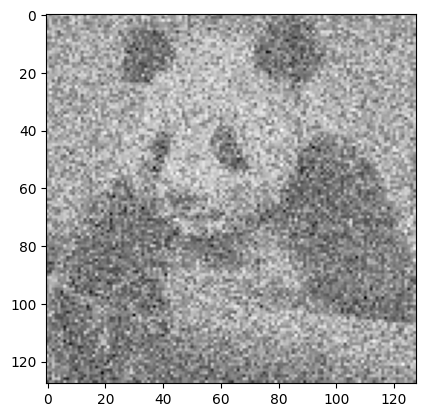

0 [3, 7, 8, 9, 11]


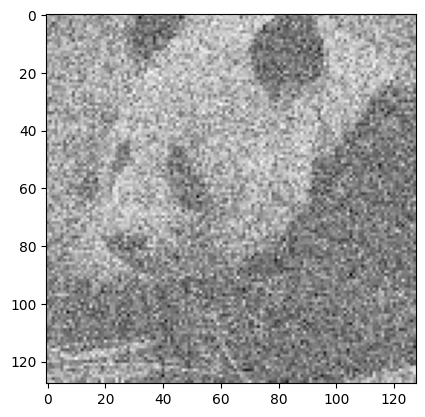

27 [3, 9, 10, 11, 12, 13, 14, 15]


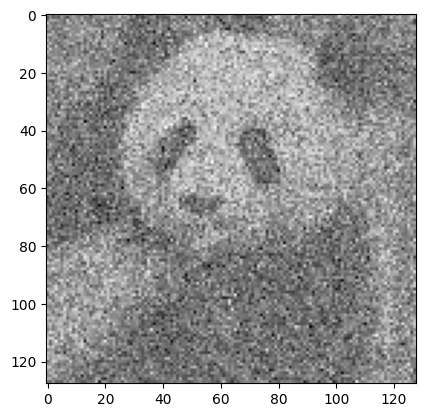

29 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


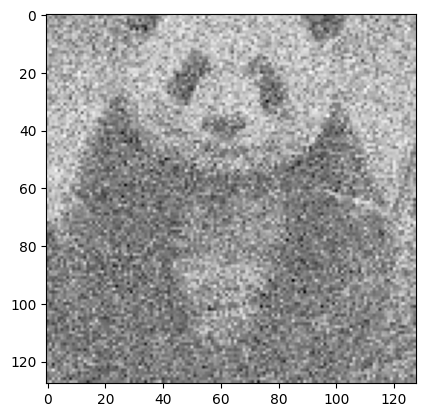

7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


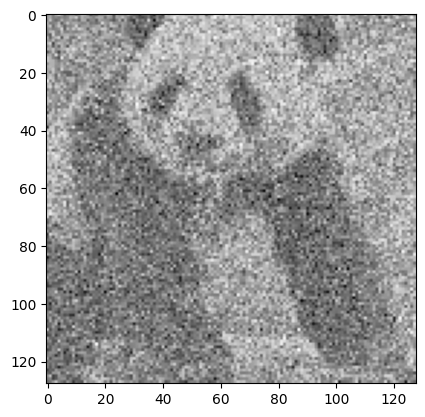

31 [9, 10, 11, 12, 13, 14, 15]


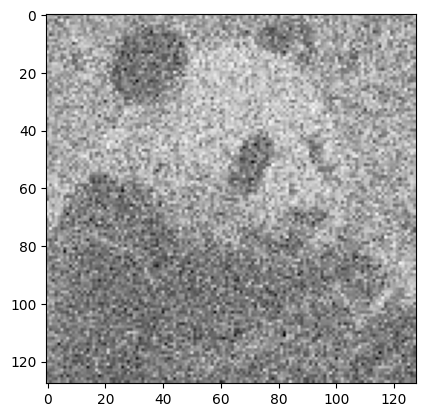

12 [11]


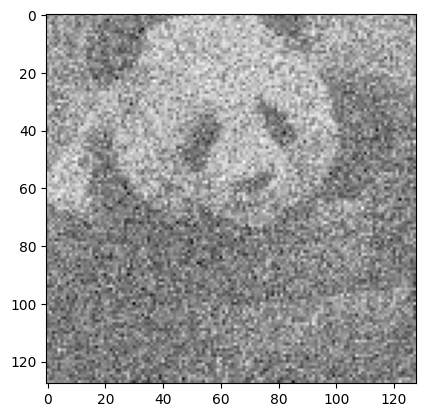

In [ ]:
# Show hard-to-classify bears for noisy model
for k in misclassified_bears_noisy:
    print(k, misclassified_bears_noisy[k])
    plt.imshow(test_images_noisy[k], cmap='Greys_r')
    plt.show()

In [ ]:
# Recall that we already have the following code somewhere above:

# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.

y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the
# list of test images. We code pandas as '0' and brown bears as '1'.
y_test = np.concatenate([np.zeros(50), np.ones(50)])

In [ ]:
# LOGISTIC REGRESSION for noisy data

# flatten training and testing arrays
X_train = np.array(train_images_noisy).reshape(500,128*128)
X_test = np.array(test_images_noisy).reshape(100,128*128)

# create model
model_log_reg_noisy = LogisticRegression()

# train model
model_log_reg_noisy.fit(X_train, y_train)

# test the model--make predictions
y_pred = model_log_reg_noisy.predict(X_test)

# compute accuracy
accuracy = np.mean(y_pred == y_test)
print("LOGISTIC REGRESSION ACCURACY: ", accuracy)

LOGISTIC REGRESSION ACCURACY:  0.99


In [ ]:
# LINEAR DISCRIMINANT ANALYSIS for noisy data

# can use the same trining and testing data as previous block

# create model
model_lda = LinearDiscriminantAnalysis()

# train model
model_lda.fit(X_train, y_train)

# test the model--make predictions
y_pred = model_lda.predict(X_test)

# compute accuracy
accuracy = np.mean(y_pred == y_test)
print("LDA ACCURACY: ", accuracy)


LDA ACCURACY:  0.99


Text(0.5, 0.98, 'With noise added')

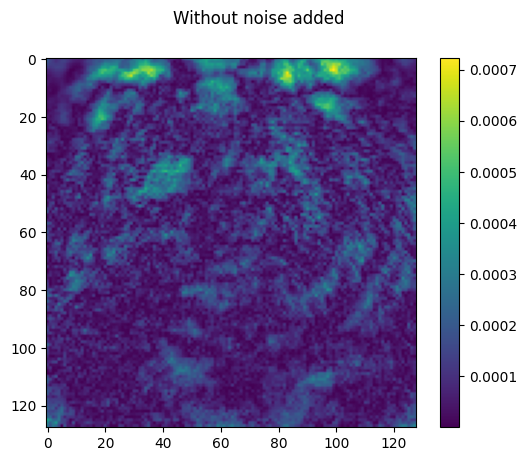

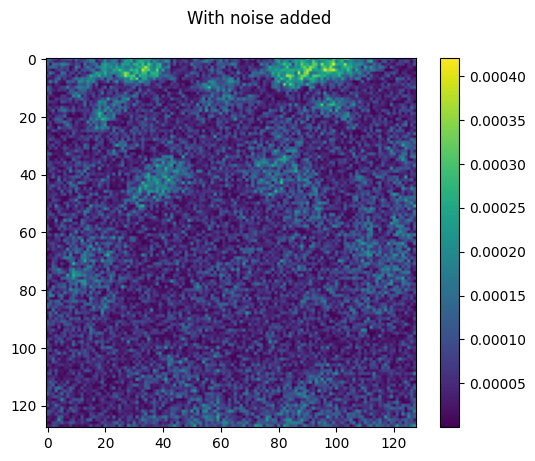

In [ ]:
# Construct the bear mask for no noise:
# Show absolute value of logistic-regression coefficients for each pixel
plt.figure(1)
plt.imshow(np.abs((model_log_reg.coef_).reshape((128,128))))
plt.colorbar()
plt.suptitle("Without noise added")

# Construct the bear mask for w/ noise:
# Show absolute value of logistic-regression coefficients for each pixel
plt.figure(2)
plt.imshow(np.abs((model_log_reg_noisy.coef_).reshape((128,128))))
plt.colorbar()
plt.suptitle("With noise added")

The additive noise slightly decreases the test accuracy for logistic regression and LDA. However, the noise actually decreased misclassification in non-parametric classification in some runs, and increased misclassification in others; it did not seem to have a significant impact in affecting misclassification rate. With noise added, we can see in the bear mask that it "dulls" out the regions that previously were important, and in fact each pixel means less overall. Other types of noise that could impact classification include noise as a result of lossy compression, such as JPEG, which can affect coloration of the images.

Overall, our accuracy across all tests were incredibly high because both the training and test data were AI generated from teh same method; essentially every piece of data is from the same "template", leading to such a high accuracy.
